## Table of content:
 [0. Introduction](#0-bullet)
<br> [1. Load dataset](#1-bullet)
<br> [2. Dickey-Fuller test](#2-bullet)
<br> [3. Forecasting models](#3-bullet)
<br> [3.1. Univariate forecasting models](#3.1-bullet)
<br> [3.1.1. Simple Exponential Smoothing (SES)](#3.1.1-bullet)
<br> [3.1.2. Holt Winter’s Exponential Smoothing (HWES)](#3.1.2-bullet)
<br> [3.1.3. ARIMA](#3.1.3-bullet)
<br> [3.1.4. SARIMA](#3.1.4-bullet)
<br> [3.2. Multivariate forecasting models](#3.2-bullet)
<br> [3.2.1. Linear models](#3.2.1-bullet)
<br> [3.2.1.1. Bayesian Ridge](#3.2.1.1-bullet)
<br> [3.2.1.2. Lasso](#3.2.1.2-bullet)
<br> [3.2.2. Tree models](#3.2.2-bullet)
<br> [3.2.2.1. Random Forest](#3.2.2.1-bullet)
<br> [3.2.2.2. XGBoost](#3.2.2.2-bullet)
<br> [3.2.2.3. LightGBM](#3.2.2.3-bullet)
<br> [3.2.3. Support Vector Machines](#3.2.3-bullet)
<br> [3.2.4. Nearest Neighbors](#3.2.4-bullet)
<br> [3.2.5. Prophet](#3.2.5-bullet)
<br> [3.2.6. Deep Learning](#3.2.6-bullet)
<br> [3.2.6.1. Tensorflow LSTM](#3.2.6.1-bullet)
<br> [4. Results](#4-bullet)

# 0. Introduction <a class="anchor" id="0-bullet"></a>

Our aim is to have a benchmark for evaluating time series forecast models. We will evaluate traditional univariate forecasting models and global forecasting models on the same dataset, using 4 error metrics:

- [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) 
- [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) 
- [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)
- [R2](https://en.wikipedia.org/wiki/Coefficient_of_determination) 

Resources:

In [323]:
# https://huggingface.co/blog/time-series-transformers
# https://forecastingdata.org/
# https://neptune.ai/blog/select-model-for-time-series-prediction-task
# https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b
# https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d
# https://towardsdatascience.com/deepar-mastering-time-series-forecasting-with-deep-learning-bc717771ce85
# <br> SARIMA vs SARIMAX: <br>
# https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# <br> Models fitted and evaluated/compared on test data: <br>
# https://github.com/jiwidi/time-series-forecasting-with-python
# <br> HWES: <br>
# https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873
# <br> BSTS: <br>
# https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html
# https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb
# https://github.com/ikatsov/tensor-house/blob/master/_basic-components/time-series/bsts-part-2-forecasting.ipynb

In [324]:
# import libraries
import pickle
import warnings
warnings.filterwarnings("ignore")
#
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
#
from bayes_opt import BayesianOptimization
from prophet import Prophet
from math import sqrt
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa import api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')

print('Tensorflow version: ',tf.__version__)

Tensorflow version:  2.7.2


In [325]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Utils:

In [381]:
# functions
def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject non-stationarity (unit-root, random-walk)" if p_value <= 0.05 else "We fail to reject non-stationarity (unit-root, random-walk)"
        ts_ax.set_title(
            'Time Series stationarity analysis \n Dickey-Fuller: p={0:.3f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std. Dev.')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
def plot_forecast_performance(df_test, yhat, label='HWES', save=True):
    fig = plt.figure(figsize = (10, 4))
    plt.plot(df_test.index, df_test.pollution_today.values, label='Actual')
    plt.plot(df_test.index, yhat.values, color='red', label=label)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('PM2.5 concentration (ug/m^3)', fontsize=10)
    plt.title('Forecasting model performance, test data', fontsize=12)
    plt.legend(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    if save:
        plt.savefig(f'plots_forecast_performance/{label}.png')
    plt.show()
    plt.close()
    
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y
    return X

def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.xticks(fontsize=16)
    plt.title("MAE, lower is better",fontsize=16)
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.xticks(fontsize=16)
    plt.title("RMSE, lower is better",fontsize=16)
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.xticks(fontsize=16)
    plt.title("MAPE, lower is better",fontsize=16)
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.xticks(fontsize=16)
    plt.title("R2, higher is better",fontsize=16)
    plt.suptitle("Model Performance, by metric",fontsize=18)
    plt.tight_layout()
    plt.savefig("results_metrics.png")
    plt.show()

# globals
METRICS = {
    "mape": mape,
    "rmse": rmse,
    "r2": r2,
    "mae": mae
}

# 1. Load dataset <a class="anchor" id="1-bullet"></a>

We will load dataset, perform data cleaning and resample to the daily level.

The description of the data is here: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [327]:
# air_pollution = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")
air_pollution = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv'
                            ,index_col=0)
air_pollution['date'] = pd.to_datetime(air_pollution[['year', 'month', 'day', 'hour']])
air_pollution = air_pollution.drop(columns=['year', 'month', 'day', 'hour'])
air_pollution.set_index('date', inplace=True)
air_pollution.columns = [
    "pollution_today",#pollution today
    "dew",# Dew Point (â„ƒ) 
    "temp",# Temperature (â„ƒ)
    "press",# Pressure (hPa) 
    "wnd_dir",# wind direction
    "wnd_spd",# wind speed
    "snow",# Cumulated hours of snow 
    "rain",# Cumulated hours of rain
]
air_pollution = air_pollution.loc[air_pollution.index>='2010-01-02']
# Fix na values with interpolation, our analysis just detected 36 days out of 1200 with nans
air_pollution["pollution_today"].fillna(0, inplace=True)
air_pollution.pollution_today = air_pollution.pollution_today.replace(
    0, np.nan).interpolate()
# Dataset had hourly measurements, we will translate this into the avg pollution, losing categorical feature wind dir
air_pollution = air_pollution.resample("D").mean()
air_pollution = air_pollution[air_pollution.pollution_today != 0]
#     #Snow and rain columns where binary columns initially but now when resampling to daily data they have values greater than 1, lets fix it
#     dataset['snow'] = (dataset.snow > 0).astype(int)
#     dataset['rain'] = (dataset.rain > 0).astype(int)
# Make it to supervised learning, every raw of datapoints at time t has
# target t+1
air_pollution["pollution_yesterday"] = (
    air_pollution["pollution_today"].tolist()[-1:]
    + air_pollution["pollution_today"].tolist()[:-1]
)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


# 2. Dickey-Fuller test <a class="anchor" id="2-bullet"></a>

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model.

First, we will plot the target variable, autocorrelation and rolling mean and std. deviation.

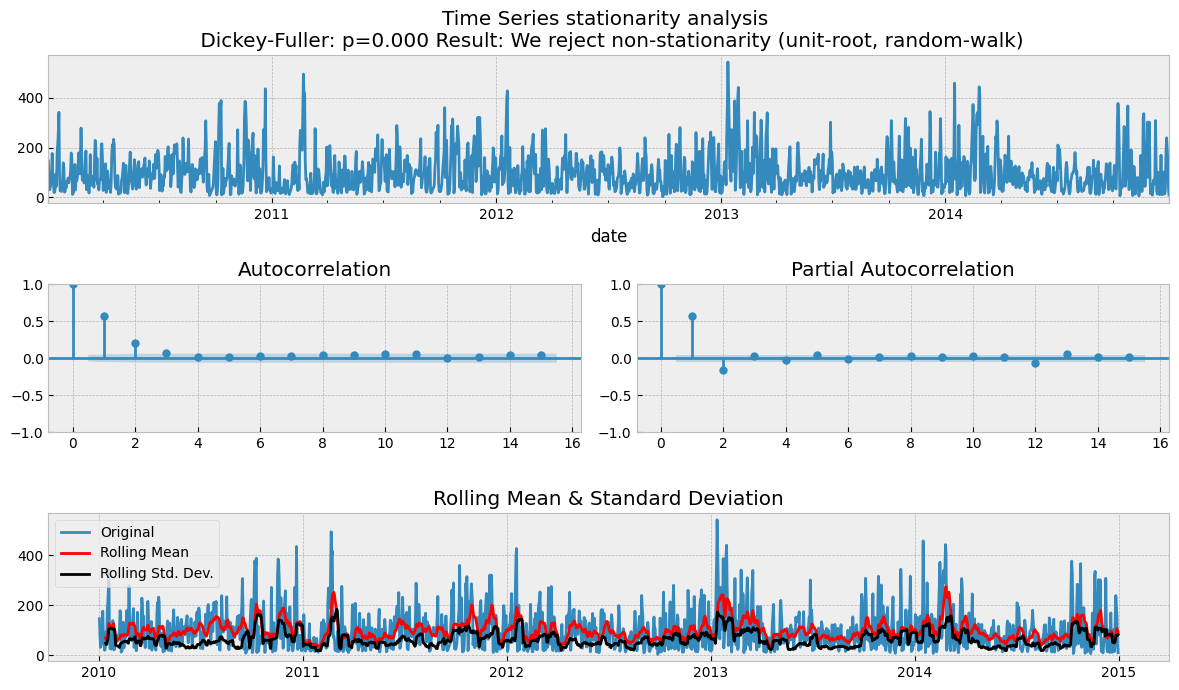

In [328]:
tsplot(air_pollution.pollution_today, lags=15)

We can see that the target variable (pollution_today) has the following characteristics:

- It does not seem to have a trend.
- May suffer autocorreation up to 3 lags.
- It suffers clusters of volatility around the winter season.
- It does not seem to be non-stationary due to the mean and volatility being fairly constant over time.

In [329]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %.3f' % result[0])
print('p-value: %.3f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.117
p-value: 0.000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The DF-test rejects the null hypothesis of non-stationarity (unit-root, random-walk).

# 3. Forecasting models <a class="anchor" id="3-bullet"></a>

Train/Test split data before modelling

In [330]:
# this dictionary contains the results in objective (loss) functions
resultsDict = {}
# this dictionary contains the predictions
predictionsDict = {}

split_date = '2014-01-01'

df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('training.csv')
df_test.to_csv('test.csv')

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [331]:
# naive mean average value
mean = df_training.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['naive_mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['naive_mean'] = mean
# naive yesterday's value
resultsDict['naive_yesterday'] = evaluate(df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['naive_yesterday'] = df_test.pollution_yesterday.values

## 3.1. Univariate forecasting models <a class="anchor" id="3.1-bullet"></a>

### 3.1.1. Simple Exponential Smoothing (SES) <a class="anchor" id="3.1.1-bullet"></a>

Also called [theta model](https://www.sciencedirect.com/science/article/abs/pii/S0169207000000662?via%3Dihub), the Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps.

In [332]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SES'] = yhat.values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 141.66it/s]


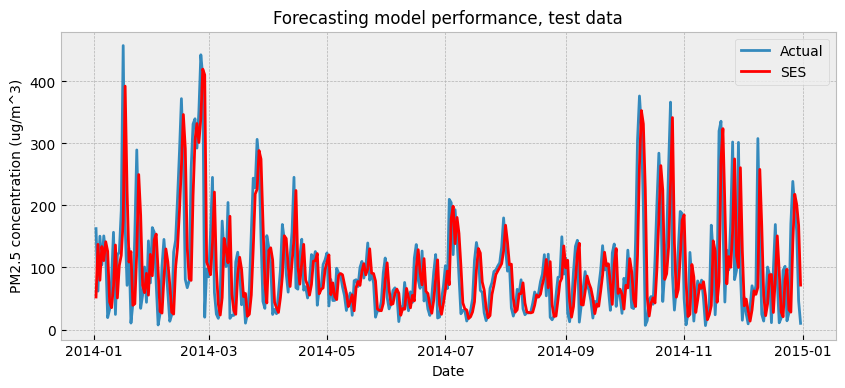

In [333]:
# Creating figure
plot_forecast_performance(df_test, yhat, label='SES')

At first glance, the performance seems good, but after a close inspection it seems that the model simply follows the data with a lag, hence it lacks predictive power.

### 3.1.2. Holt Winter’s Exponential Smoothing (HWES) <a class="anchor" id="3.1.2-bullet"></a>

Holt-Winters Exponential Smoothening ([HWES](https://link.springer.com/book/10.1007/978-3-540-71918-2)) works on the idea of smoothening the values of a univariate time series to use them for forecasting future values. The idea is to assign exponentially decreasing weights giving more importance to more recent incidents. So, when we move back in time, we would see diminishing weights.

In [334]:
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 145.75it/s]


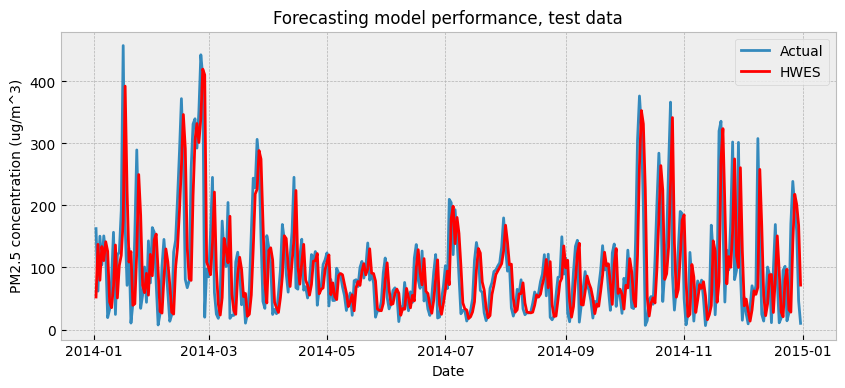

In [335]:
plot_forecast_performance(df_test, yhat, label='HWES')

At first glance, the model fit seems remarkably similar to the SES method.

### 3.1.3. Autoregressive integrated moving average (ARIMA) <a class="anchor" id="3.1.3-bullet"></a>

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

Non-stationarity series will require the level of differencing (d) > 0 in an ARIMA model. 

We select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using the PACF and ACF plots.

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.


In [336]:
# building the model (auto)
autoModel = pm.auto_arima(df_training.pollution_today, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18232.724, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16461.265, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17191.945, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16462.630, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16462.086, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16455.385, Time=0.20 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16266.588, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16869.411, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16217.321, Time=0.39 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16711.266, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [337]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA_{0}'.format(order).replace(' ','')] = evaluate(
    df_test.pollution_today, yhat)
predictionsDict['AutoARIMA_{0}'.format(order).replace(' ','')] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [01:00<00:00,  6.05it/s]


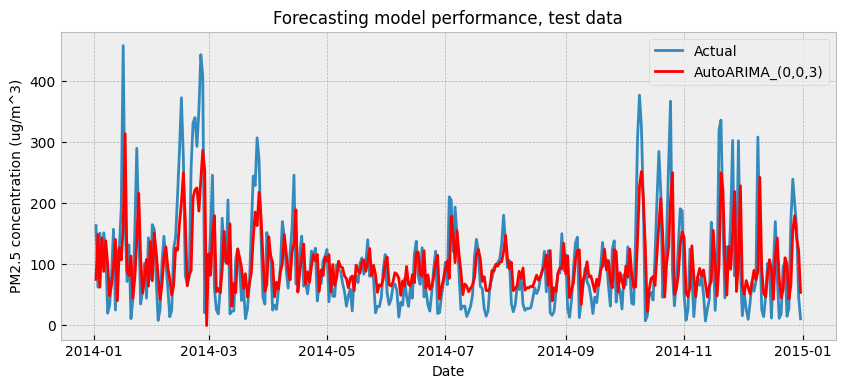

In [338]:
plot_forecast_performance(df_test, yhat, label='AutoARIMA_{0}'.format(order).replace(' ',''))

The performance of the model is decent, but once again after a close inspection it can be seen that the model simply follows the data with a lag, hence it lacks predictive power.

### 3.1.4. Seasonal Autoregressive Integrated Moving-Average (SARIMA) <a class="anchor" id="3.1.4-bullet"></a>

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

*Trend Elements*:

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.

*Seasonal Elements*:

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period. For example, an m of 12 for monthly data suggests a yearly seasonal cycle.

SARIMA notation: SARIMA(p,d,q)(P,D,Q,m)


In [339]:
# building the model (auto)
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16199.897, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16788.406, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16229.161, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16265.917, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18232.724, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16200.349, Time=0.35 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16200.355, Time=0.34 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16203.879, Time=0.88 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16203.861, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16198.453, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16196.487, Time=0.57 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16198.378, Time=0.62 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16198.371, Time=0.72 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16200.253, Time=0.56 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [340]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX_{0},{1}'.format(order, seasonalOrder).replace(' ','')] = evaluate(
    df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX_{0},{1}'.format(
    order, seasonalOrder).replace(' ','')] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:24<00:00, 14.69it/s]


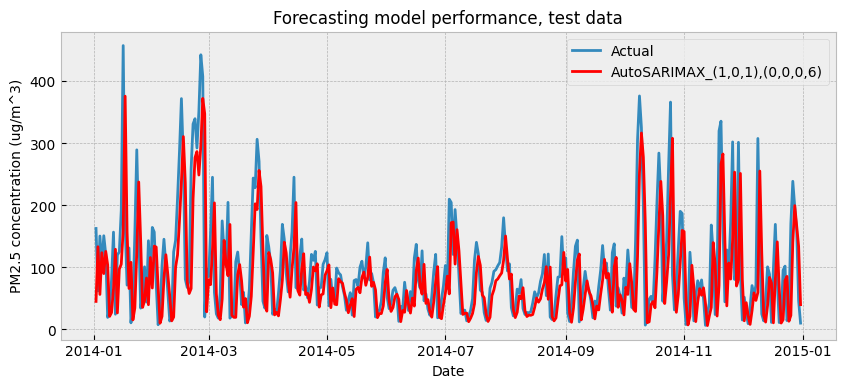

In [341]:
plot_forecast_performance(df_test, yhat, label='AutoSARIMAX_{0},{1}'.format(order, seasonalOrder).replace(' ',''))

The performance of the model is good, but once again after a close inspection it can be seen that the model simply follows the data with a lag, hence it lacks predictive power.

### 3.2. Multivariate forecasting models <a class="anchor" id="3.2-bullet"></a>

We will create the time series features:

In [342]:
X_train_df, y_train = create_time_features(
    df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

### 3.2.1. Linear models <a class="anchor" id="3.2.1-bullet"></a>

### 3.2.1.1. [Bayesian regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) <a class="anchor" id="3.2.1.1-bullet"></a>

L2 regularisation: adds the “squared magnitude” of the coefficient as a penalty term to the loss function.

In [343]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['BayesianRidge'] = yhat

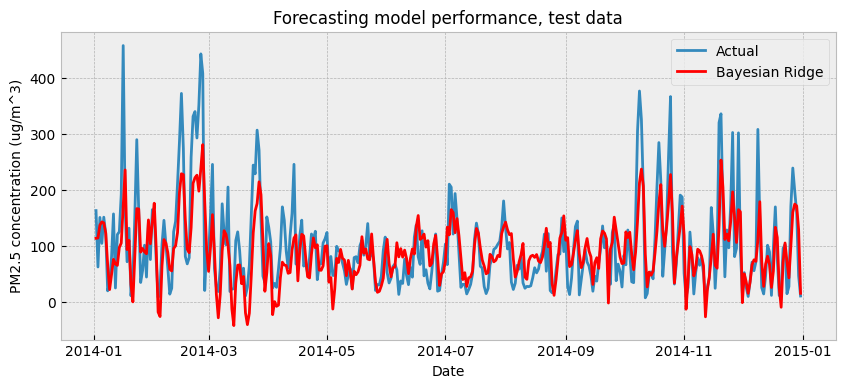

In [344]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='Bayesian Ridge')

### 3.2.1.2. [Lasso regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso) <a class="anchor" id="3.2.1.2-bullet"></a>

L1 regularisation: adds the “absolute value of magnitude” of the coefficient as a penalty term to the loss function.

In [345]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lasso'] = yhat

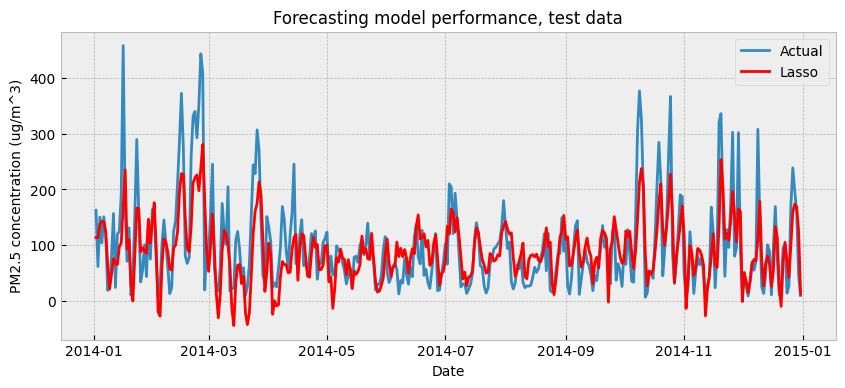

In [346]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='Lasso')

### 3.2.2. Tree models <a class="anchor" id="3.2.2-bullet"></a>

### 3.2.2.1. [Random Forrest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) <a class="anchor" id="3.2.2.1-bullet"></a>

In [347]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['RandomForest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['RandomForest'] = yhat

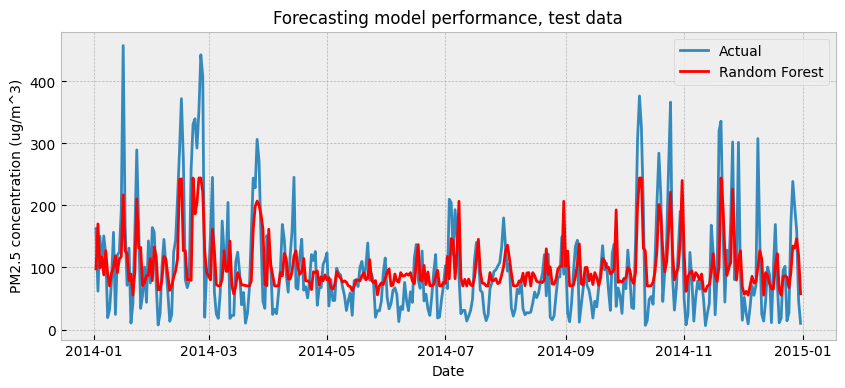

In [348]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='Random Forest')

### 3.2.2.2. [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html) <a class="anchor" id="3.2.2.2-bullet"></a>

In [349]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

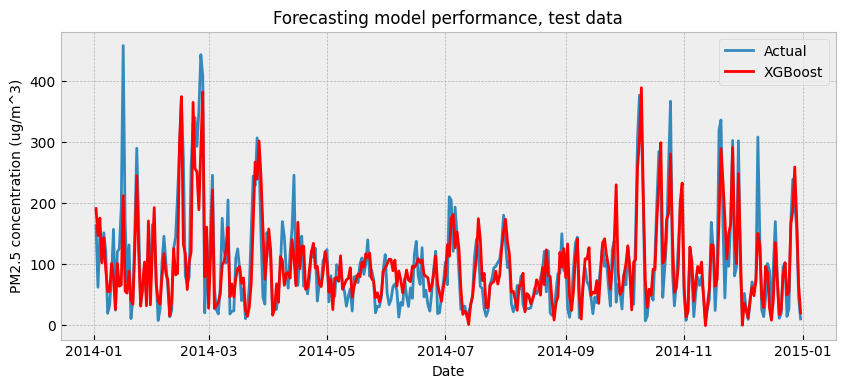

In [350]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='XGBoost')

### 3.2.2.3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/Features.html) <a class="anchor" id="3.2.2.3-bullet"></a>

In [351]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['lightGBM'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['lightGBM'] = yhat

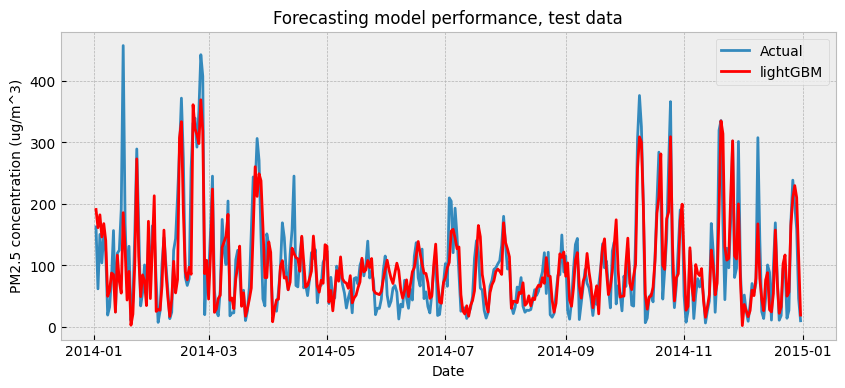

In [352]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='lightGBM')

### 3.2.3. [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#regression) <a class="anchor" id="3.2.3-bullet"></a>

We will use a SVM Regression model with the Radial Basis Function (RBF) kernel.

In [353]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM_RBF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM_RBF'] = yhat

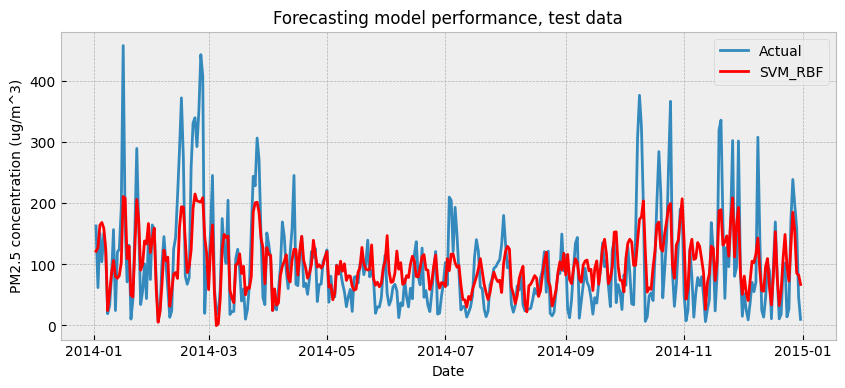

In [354]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='SVM_RBF')

### 3.2.4. [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html) <a class="anchor" id="3.2.4-bullet"></a>

In [355]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['KNNs'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['KNNs'] = yhat

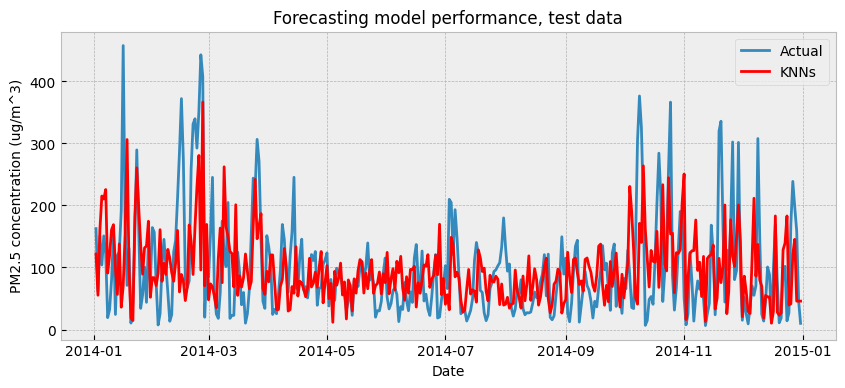

In [356]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='KNNs')

### 3.2.5. Prophet <a class="anchor" id="3.2.5-bullet"></a>

Prophet is a model released by [facebook](https://github.com/facebook/prophet). It is essentially a curve fitting approach, very similar in spirit to how Bayesian Structural Time Series (BSTS) models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.

In [357]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [358]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet_Multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet_Multivariate'] = yhat.yhat.values

22:42:57 - cmdstanpy - INFO - Chain [1] start processing
22:42:58 - cmdstanpy - INFO - Chain [1] done processing


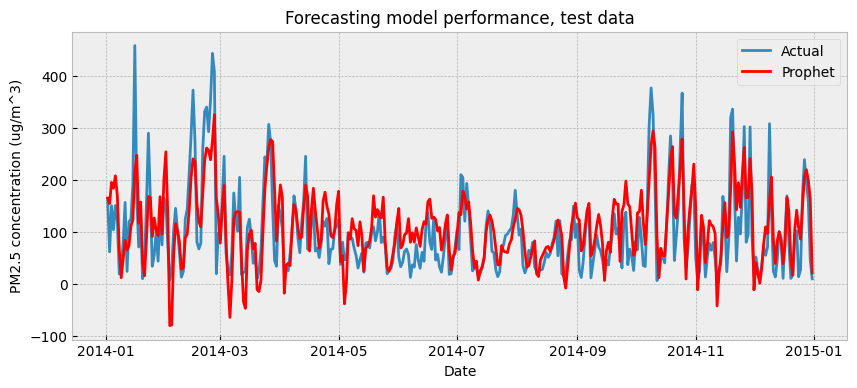

In [359]:
plot_forecast_performance(df_test, yhat.yhat, label='Prophet')

### 3.2.6. Deep Learning <a class="anchor" id="3.2.6-bullet"></a>

### 3.2.6.1 Tensorflow LSTM <a class="anchor" id="3.2.6.1-bullet"></a>

[LSTM](https://www.tensorflow.org/guide/keras/rnn) are a special type of neural network architecture: Recurrent Neural Networks (RNN).
<br>RNN are a class of neural networks that is powerful for modeling sequence data such as time series or natural language.

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value

In [360]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [361]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [362]:
EVALUATION_INTERVAL = 200
EPOCHS = 5
model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/5
200/200 [==============================] - 7s 30ms/step - loss: 52.4529 - val_loss: 44.7971
Epoch 2/5
200/200 [==============================] - 5s 26ms/step - loss: 35.8190 - val_loss: 35.4664
Epoch 3/5
200/200 [==============================] - 5s 25ms/step - loss: 30.1695 - val_loss: 30.5022
Epoch 4/5
200/200 [==============================] - 5s 25ms/step - loss: 27.2306 - val_loss: 30.6047
Epoch 5/5
200/200 [==============================] - 5s 25ms/step - loss: 25.1156 - val_loss: 30.0394


In [363]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['TF_LSTM'] = evaluate(y_test, yhat)
predictionsDict['TF_LSTM'] = yhat

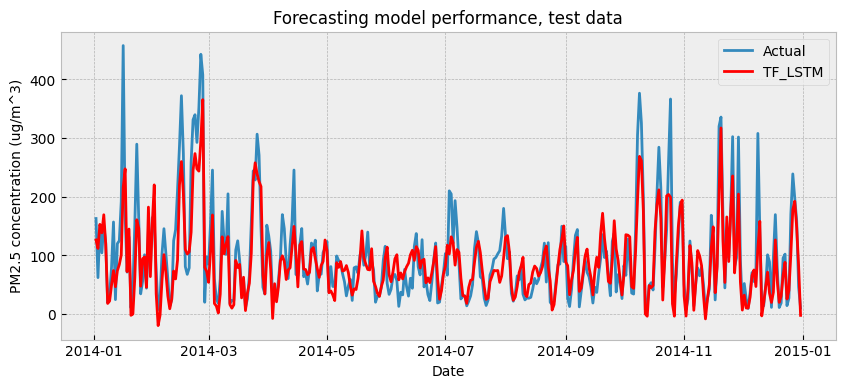

In [364]:
plot_forecast_performance(df_test, pd.DataFrame(yhat), label='TF_LSTM')

# 4. Results <a class="anchor" id="4-bullet"></a>

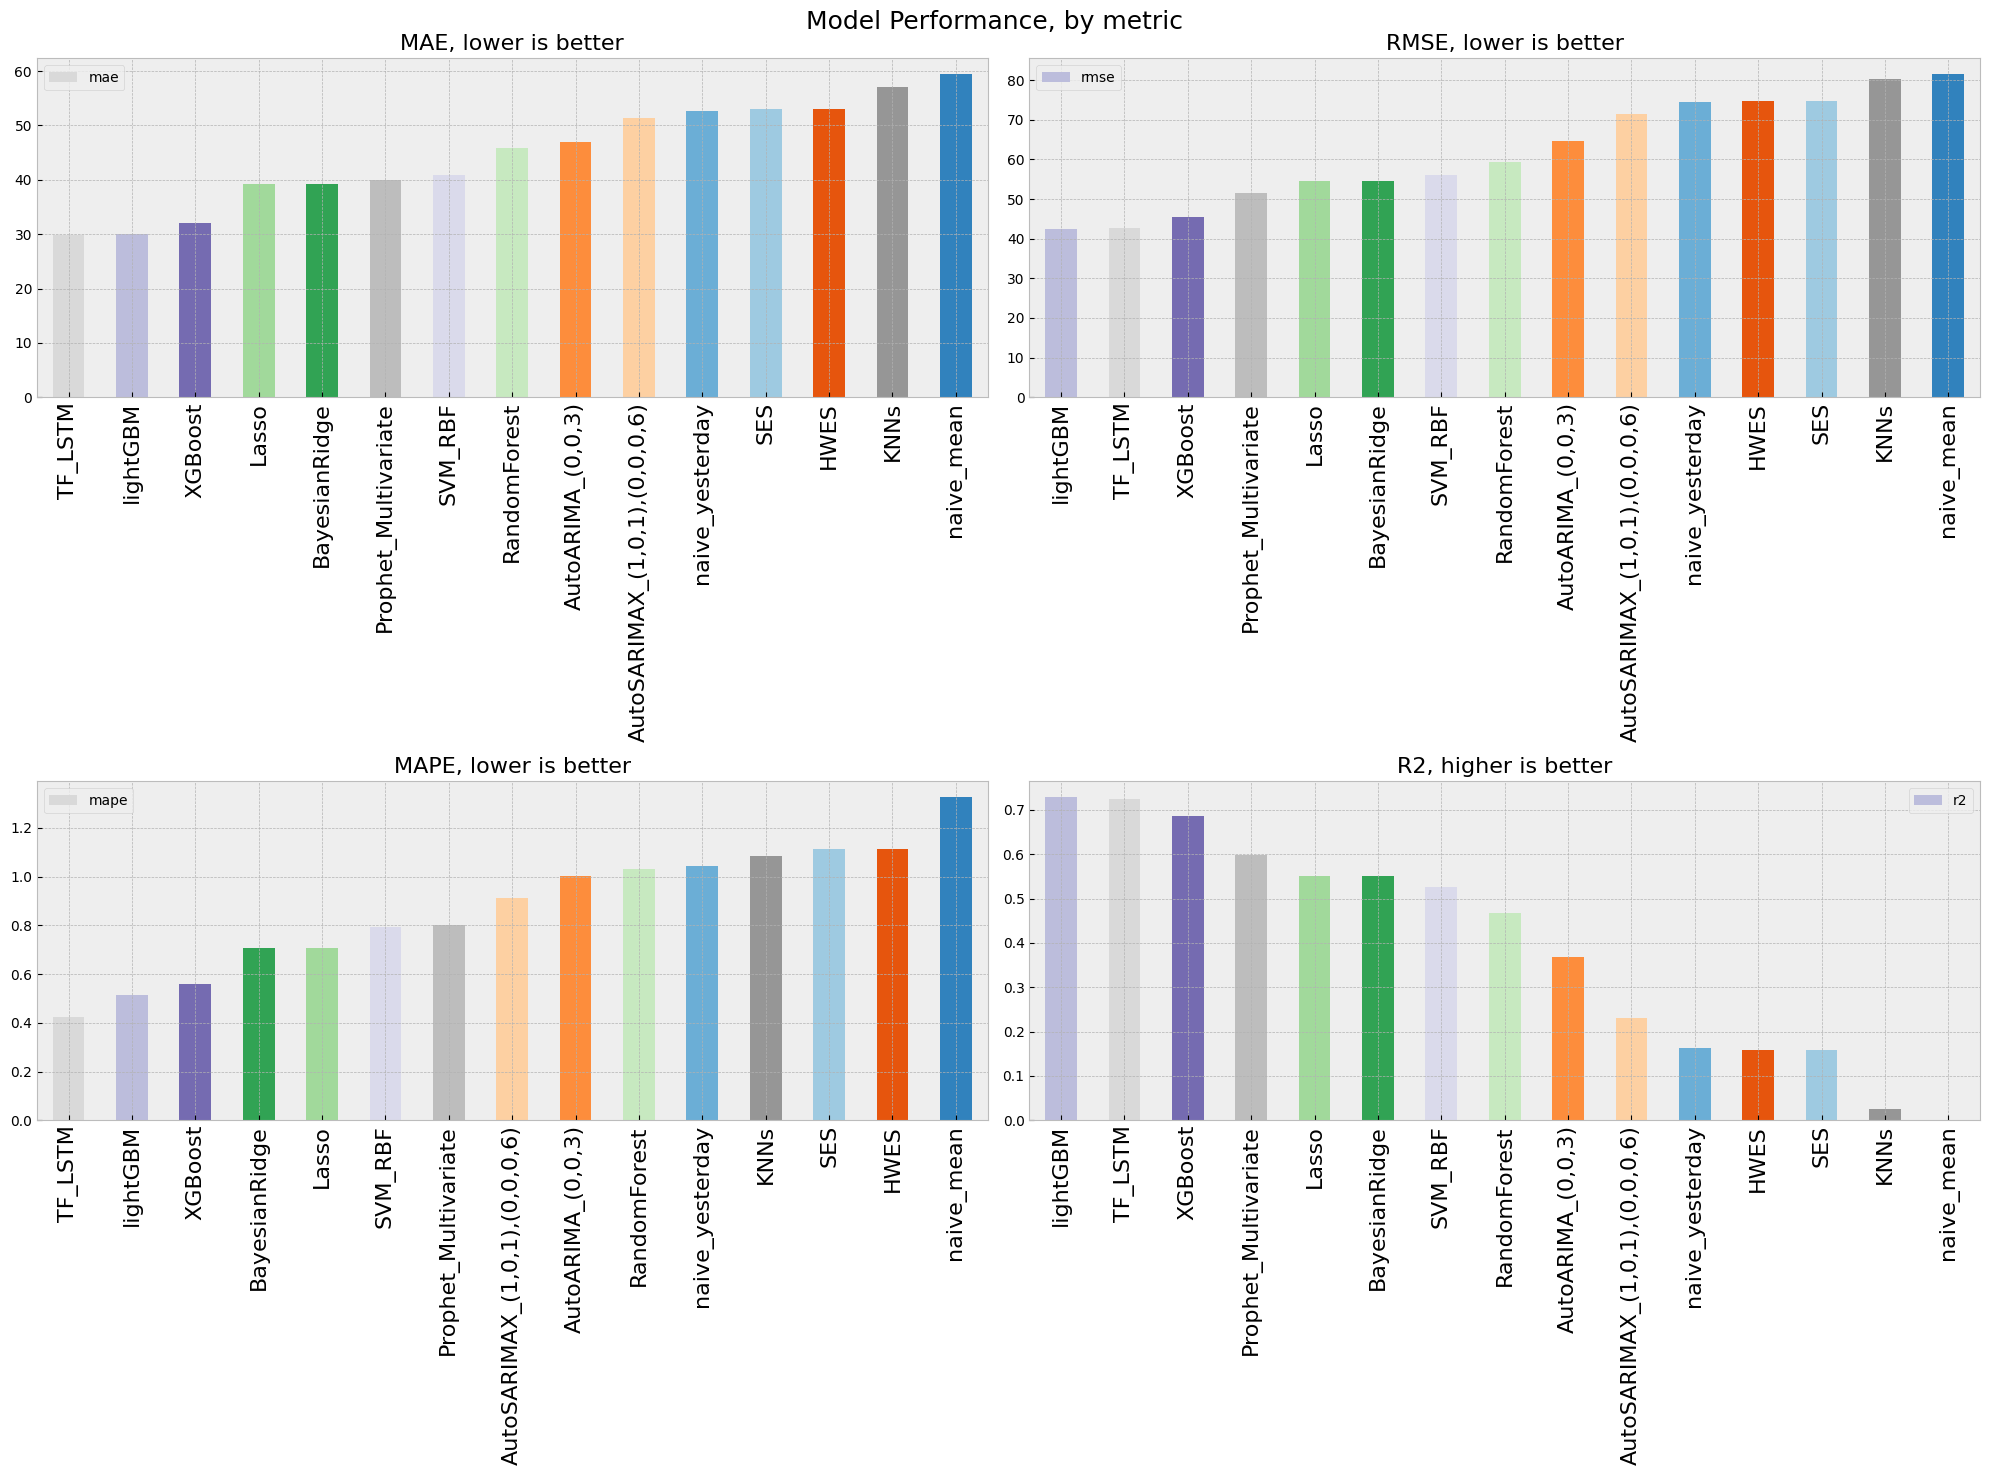

In [382]:
bar_metrics(resultsDict)

Plot residuals by model:

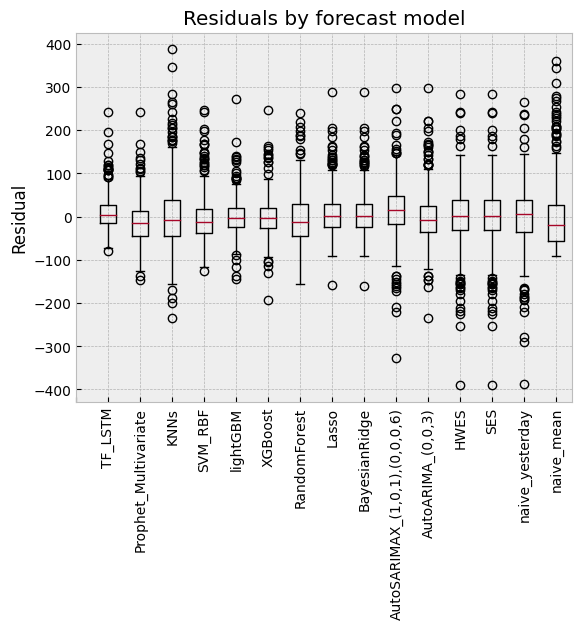

In [366]:
df_test = pd.read_csv("test.csv")
residuals = [df_test.pollution_today.values - predictionsDict[u]
             for u in predictionsDict.keys()]
residuals.reverse()
plt.boxplot(residuals)
ticks = list(predictionsDict.keys())
ticks.reverse()
ticks = [''] + ticks
rang = range(0, len(ticks))
plt.xticks(rang, ticks, rotation='vertical')
plt.ylabel('Residual')
plt.title('Residuals by forecast model')
plt.savefig("residuals.png")
pass

Choosing the right metric for to evaluate a forecasting model is a big challenge and it will depend on the forecasting needs.

One lesson from this tutorial is the importance of extra features to describe the time series. We have seen how most of the models that used the extra features outperforms traditional univariate time series models.

The LSTM model comes up with such good scores relative to the tree models with such a small dataset, which is a little bit surprising given that deep learning methods are known for their good performance on large datasets.